In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from astropy.io import ascii
%pylab inline
import matplotlib
import matplotlib.colors as colors
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Populating the interactive namespace from numpy and matplotlib


In [79]:
# Pandas reads from *lots* of different data sources
data = pd.read_csv('../data/galaxy.csv', sep= ',') #MJ path
#data = pd.read_csv('galaxy1.csv', sep= ',') #TUGBA path

In [82]:
central_mask = (data["StarFormationRate"]!=0)
array = data.as_matrix()
array = array[central_mask]
array[:,10] = np.log10(array[:,10]/array[:,9]) #biz burdan log SSFR
median_logssfr = np.median(array[:,10]) #we found the median logssfr for all the galaxies in Eagle.

In [106]:
def central_filterer(logmmin, logmmax):
    """
    this function 
    keeps the central galaxies with non-zero SFR with logmstar 
    between logmmin, logmmax
    
    return:
    all galaxies with the above properties
    red galaxies with the baove properties
    blue galaxies with the above properties
    """
    
    central_mask = (data["SubGroupNumber"]==0)&(data["StarFormationRate"]!=0)
    array = data.as_matrix()
    array = array[central_mask]
    array[:,10] = np.log10(array[:,10]/array[:,9]) #biz burdan log SSFR
    array[:,9] = np.log10(array[:,9]) #buda logMstar
    
    
    
    mstar_mask = (array[:,9]>logmmin)&(array[:,9]<logmmax)
    
    array= array[mstar_mask,:]
    #median_logssfr = np.median(array[:,10])

    
    red_mask = array[:,10] < median_logssfr
    blue_mask = array[:,10] > median_logssfr
        
    red = array[red_mask,:]
    blue = array[blue_mask,:]
    tot= array 
    
    return tot,red, blue
    
    
def filterer(logmmin, logmmax):
    """
    this function 
    keeps the central galaxies with non-zero SFR with logmstar 
    between logmmin, logmmax
    
    return:
    all galaxies with the above properties
    red galaxies with the baove properties
    blue galaxies with the above properties
    """
    
    central_mask = (data["StarFormationRate"]!=0)
    array = data.as_matrix()
    array = array[central_mask]
    array[:,10] = np.log10(array[:,10]/array[:,9]) #biz burdan log SSFR
    array[:,9] = np.log10(array[:,9]) #buda logMstar
    
    mstar_mask = (array[:,9]>logmmin)&(array[:,9]<logmmax)
    
    array= array[mstar_mask,:]
        
    red_mask = array[:,10] < median_logssfr
    blue_mask = array[:,10] > median_logssfr
    
        
    red = array[red_mask,:]
    blue = array[blue_mask,:]
    tot= array 
    
    return tot,red, blue


def modify(x):
        
    mask = np.abs(x) > 50
    
    x[mask] = 100 - np.abs(x[mask])
    
    return np.abs(x)


def func(amin, bmax, data1, data2):
    
    """this function returns average number of 
    data1 points and data2 points between amin and bmax"""
    
    zebra = []

    for point in data1:
        
        matrix = point[None,:]-data2
        matrix = modify(matrix)
        
        distance_to_point = np.sum((matrix)**2  ,  axis = 1 )**0.5 #distance from all the points in fake data to the point
        A = (amin < distance_to_point) & ( distance_to_point < bmax)
        x = len(distance_to_point[A])
        zebra.append(x)
    zebra= np.array(zebra)
    return np.average(zebra)

def func2(logmin,logmmax, galaxy_type1, galaxy_type2):
    """
    it returns func at (2,4),(4,6) etc. sonun da (2,4) için net sonucu verir.  """
    
    tot, red, blue = central_filterer(logmin, logmmax)

    
    
    if galaxy_type1 == 'red':
        FAKE_DATA1 = red[:,4:7] #bu demek ki biz tüm kolonı tutuyoruz ve sadece 4-7 arasındakı kolonları seçiyoruz.
    if galaxy_type1 == 'blue':
        FAKE_DATA1 = blue[:,4:7]
    if galaxy_type1 == 'tot':
        FAKE_DATA1 = tot[:,4:7]
   
    tot, red, blue = filterer(logmin, logmmax) # filterer gives us all galaxies but central_filterer gives us just center galaxies.
    
    #print "tot shape", tot.shape , red.shape , blue.shape

    if galaxy_type2 == 'red':
        FAKE_DATA2 = red[:,4:7]
    if galaxy_type2 == 'blue':   #sns.distplot(array[:,10], norm_hist=False,kde=False)
        FAKE_DATA2 = blue[:,4:7]
    if galaxy_type2 == 'tot':
        FAKE_DATA2 = tot[:,4:7]
    
    list_average = []
    
    lister = [2,3,4,5,6,8,9,10,11,12]
    for i in lister:
        average = func(i,i+1,FAKE_DATA1,FAKE_DATA2)
        list_average.append(average)
    return np.array(list_average)

In [118]:
def edge(index , nsub):
    '''returns edges of a sub-box of 
       a given index
    '''
    box_size = 100.
    subbox_size = 1.*box_size / nsub

    zi = (index / (nsub**2)) * subbox_size
    i2 = index % (nsub**2)
    yi = (i2 / nsub) * subbox_size
    i3 = i2 % nsub
    xi = (i3) * subbox_size

    return xi , yi , zi

def mask_catalog(cat , subvol_index , nsub):
    '''This divides the box into nsub^3 
       sub-boxes. And then it takes out 
       the sub-box ccorresponding to subvol_index!
       Boom!
    '''
    box_size = 100
    subbox_size = 1.*box_size / nsub
    
    xi , yi , zi  = edge(subvol_index, nsub)
    submask = (xi <cat[:, 4]) * \
                       (cat[:, 4] < xi + subbox_size) * \
                       (yi <cat[:, 5]) * \
                       (cat[:, 5] < yi + subbox_size) * \
                       (zi <cat[:, 6]) *  \
                       (cat[:, 6] < zi + subbox_size)
    
    #print cat.shape , cat[~submask,:].shape
    return cat[~submask]

In [108]:
def func_index(amin, bmax, data1, data2):
    
    """this function returns average number of 
    data1 points and data2 points between amin and bmax"""
    
    zebra = []

    for point in data1:
        
        matrix = point[None,:]-data2
        matrix = modify(matrix)
        
        distance_to_point = np.sum((matrix)**2  ,  axis = 1 )**0.5 #distance from all the points in fake data to the point
        A = (amin < distance_to_point) & ( distance_to_point < bmax)
        x = len(distance_to_point[A])
        zebra.append(x)
    zebra= np.array(zebra)
    return np.average(zebra)

def func2_index(logmin,logmmax, galaxy_type1, galaxy_type2, index, nsub):
    """
    it returns func at (2,4),(4,6) etc. sonun da (2,4) için net sonucu verir.  """
    
    tot, red, blue = central_filterer(logmin, logmmax)
    
    tot , red, blue = mask_catalog(tot, index, nsub), mask_catalog(red, index, nsub), mask_catalog(blue, index, nsub)
    
    
    if galaxy_type1 == 'red':
        FAKE_DATA1 = red[:,4:7] #bu demek ki biz tüm kolonı tutuyoruz ve sadece 4-7 arasındakı kolonları seçiyoruz.
    if galaxy_type1 == 'blue':
        FAKE_DATA1 = blue[:,4:7]
    if galaxy_type1 == 'tot':
        FAKE_DATA1 = tot[:,4:7]
   
    tot, red, blue = filterer(logmin, logmmax) # filterer gives us all galaxies but central_filterer gives us just center galaxies.
    


    if galaxy_type2 == 'red':
        FAKE_DATA2 = red[:,4:7]
    if galaxy_type2 == 'blue':   #sns.distplot(array[:,10], norm_hist=False,kde=False)
        FAKE_DATA2 = blue[:,4:7]
    if galaxy_type2 == 'tot':
        FAKE_DATA2 = tot[:,4:7]
    
    list_average = []
    
    lister = [2,3,4,5,6,8,9,10,11,12]
    for i in lister:
        average = func(i,i+1,FAKE_DATA1,FAKE_DATA2)
        list_average.append(average)

    return np.array(list_average)

In [124]:
def red_fraction(logmmin, logmmax, nsub):
    
    tot_red_subs = []
    red_red_subs = []
    tot_blue_subs = []
    red_blue_subs = []

    for index in range(nsub**3):
        
        tot_red_subs.append(func2_index(logmmin,logmmax,'red','tot', index, nsub))
        red_red_subs.append(func2_index(logmmin,logmmax,'red','red', index, nsub))
        tot_blue_subs.append(func2_index(logmmin,logmmax,'blue','tot', index, nsub))
        red_blue_subs.append(func2_index(logmmin,logmmax,'blue','red', index, nsub))

        
    tot_red_subs = np.array(tot_red_subs)
    red_red_subs = np.array(red_red_subs)
    tot_blue_subs = np.array(tot_blue_subs)
    red_blue_subs = np.array(red_blue_subs)

    tot_red_errs =  np.cov(tot_red_subs.T) * (nsub ** 3 - 1)**2 /nsub ** 3  
    red_red_errs =  np.cov(red_red_subs.T) * (nsub ** 3 - 1)**2 / nsub ** 3
    tot_blue_errs = np.cov(tot_blue_subs.T) * (nsub ** 3 - 1)**2 / nsub ** 3
    red_blue_errs =  np.cov(red_blue_subs.T) *(nsub ** 3 - 1)**2 /nsub ** 3
    
    
    tot_red_err = np.diag(tot_red_errs)**.5
    red_red_err = np.diag(tot_red_errs)**.5
    tot_blue_err = np.diag(tot_blue_errs)**.5
    red_blue_err = np.diag(red_blue_errs)**.5
    
    
    tot_red = func2(logmmin,logmmax,'red','tot')
    red_red = func2(logmmin,logmmax,'red','red')
    tot_blue = func2(logmmin,logmmax,'blue','tot')
    red_blue = func2(logmmin,logmmax,'blue','red')
    
    fred_red = np.array(red_red)*1.  / np.array(tot_red) #equation 1 of paper
    fred_blue = np.array(red_blue)*1.  / np.array(tot_blue) #equatıon 2 of paper
    
    var_fred_red = (red_red_err**2/red_red**2 + tot_red_err**2/tot_red**2)*(red_red/tot_red)**2.
    fred_red_err = var_fred_red**.5
    
    var_fred_blue = (red_blue_err**2/red_blue**2 + tot_blue_err**2/tot_blue**2)*(red_blue/tot_blue)**2.
    fred_blue_err = var_fred_blue**.5
    
    return fred_red, fred_red_err, fred_blue, fred_blue_err
        

In [125]:
A , B , C , D = red_fraction(10.3, 10.5, 3)

In [126]:
A , B , C , D

(array([0.78431373, 0.86111111, 0.87861272, 0.82722513, 0.82142857,
        0.78980892, 0.77620397, 0.83292978, 0.78612717, 0.82735043]),
 array([0.2560761 , 0.36085534, 0.24763923, 0.25599709, 0.14518908,
        0.15734598, 0.12983327, 0.14372901, 0.15922572, 0.10896929]),
 array([0.84615385, 0.65217391, 0.84615385, 0.83928571, 0.86764706,
        0.78095238, 0.71666667, 0.77952756, 0.81132075, 0.79411765]),
 array([0.28620669, 0.32745469, 0.28650122, 0.4872692 , 0.33280188,
        0.19515701, 0.20859004, 0.16431411, 0.16718539, 0.14416764]))

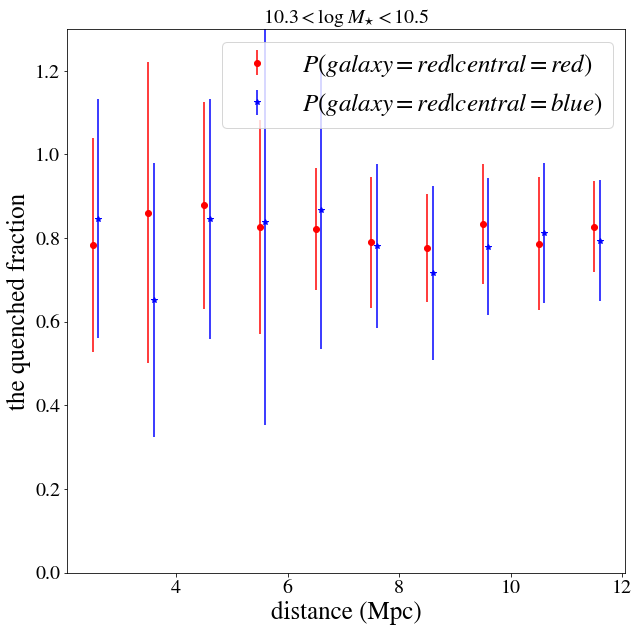

In [138]:
logmmin, logmmax = 10.3, 10.5


plt.figure(figsize=(10,10))

x = [2.5 +i for i in range(10)]
x = np.array(x)


plt.errorbar(x, A, B, fmt = "o", color ="r" , label = '$P(galaxy = red | central = red )$')
plt.errorbar(x+.1, C, D, fmt = "*", color ="b" , label= '$P(galaxy = red | central = blue )$')
plt.title(str(logmmin)+'$<\log \; M_{\star}<$'+str(logmmax), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("the quenched fraction",fontsize=25)
plt.xlabel("distance (Mpc)",fontsize=25)
plt.legend(fontsize = 25)
plt.ylim([0,1.3])
plt.show()